# Convolutional Autoeconder with two decoders
This code trains a simple autoencoder neural network using convolutional
layers. However, an additional decoder is compled to the bottleneck where
the decoder output is trained with next time step.The contraction and
expansion of the implemented neural network used only convolutional layers. 
Therefore, it does not rely on maxpooling or upsampling layers. Instead, 
it was used strides to control the contraction and expansion of the neural
network. Also, in the decoder part it was used a decovolutional process.

For the latent space it was used a fully connected layer with an additional
fully connected layer in sequence, to connect the latent space with the
decoder convolutional layer.

The neural network architecture with the activation function is stated below.

## Prelimiary steps

In [ ]:
# Optional cell if the current path already has the data and the file utils.py
%cd .. 
%cd .. 

In [2]:
# Import modules
import h5py
import keras.layers as layers
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Model

from utils import plot_red_comp, slicer, split, format_data


# Path to store training data
save_path = "./tests/jupyter-notebooks/models/train_dual_model_{}"

Using TensorFlow backend.


###  Data manipulation

In [3]:
# Selecting data
dt_fl = "nn_data.h5"
dt_dst = "scaled_data"

# The percentage for the test is implicit
n_train = 0.8
n_valid = 0.1

# Select the variable to train
# 0: Temperature - 1: Pressure - 2: Velocity - None: all
var = 2

Load the selected data and then split it.

In [4]:
# Open data file
f = h5py.File(dt_fl, "r")
dt = f[dt_dst]

x_data, y_data = format_data(dt, wd=2, var=2, get_y=True, cont=True)
x_data = x_data[:,0]

# Split data file
idxs = split(x_data.shape[0], n_train, n_valid)
slc_trn, slc_vld, slc_tst = slicer(x_data.shape, idxs)
# Slice data
x_train = x_data[slc_trn]
y_train = y_data[slc_trn]
x_val = x_data[slc_vld]
y_val = y_data[slc_vld]

### Autoencoder settings

In [5]:
# Activation function
act = "tanh"  # Convolutional layers activation function
act_lt = "tanh"  # Latent space layers activation function
# Number of filters of each layer
flt = [3, 9, 27]
# Filter size
flt_size = 5
# Strides of each layer
strd = [2, 2, 5]
# Latent space size
lt_sz = 50

# Training settings
opt = "adam"  # Optimizer
loss = "mse"
epochs = 60
batch_size = 64

### Build autoencoder

In [6]:
# Build the autoencoder neural network
tf.keras.backend.clear_session()
flt_tp = (flt_size, flt_size)
conv_kwargs = dict(activation=act, padding="same")
# Encoder
inputs = layers.Input(shape=x_train.shape[1:])
e = layers.Conv2D(flt[0], flt_tp, strides=strd[0], **conv_kwargs)(inputs)
e = layers.Conv2D(flt[1], flt_tp, strides=strd[1], **conv_kwargs)(e)
e = layers.Conv2D(flt[2], flt_tp, strides=strd[2], **conv_kwargs)(e)

# Latent space
l = layers.Flatten()(e)
l = layers.Dense(lt_sz, activation=act_lt)(l)

# Latent to decoder same
dn_flt = flt[-1]
d_shp = (x_train.shape[1:-1] / np.prod(strd)).astype(int)
d_sz = np.prod(d_shp) * dn_flt
d = layers.Dense(d_sz, activation=act_lt)(l)
d = layers.Reshape(np.hstack((d_shp, dn_flt)))(d)
# Decoder same
d = layers.Conv2DTranspose(flt[-1], flt_tp, strides=strd[-1], **conv_kwargs)(d)
d = layers.Conv2DTranspose(flt[-2], flt_tp, strides=strd[-2], **conv_kwargs)(d)
d = layers.Conv2DTranspose(flt[-3], flt_tp, strides=strd[-3], **conv_kwargs)(d)
decoded = layers.Conv2DTranspose(
    x_train.shape[-1], flt_tp, activation="linear", padding="same", name="dec_same"
)(d)
# Decoder next step
dp = layers.Dense(d_sz, activation=act_lt)(l)
dp = layers.Reshape(np.hstack((d_shp, dn_flt)))(dp)
# Decoder same
dp = layers.Conv2DTranspose(flt[-1], flt_tp, strides=strd[-1], **conv_kwargs)(dp)
dp = layers.Conv2DTranspose(flt[-2], flt_tp, strides=strd[-2], **conv_kwargs)(dp)
dp = layers.Conv2DTranspose(flt[-3], flt_tp, strides=strd[-3], **conv_kwargs)(dp)
decoded_pred = layers.Conv2DTranspose(
    x_train.shape[-1], flt_tp, activation="linear", padding="same", name="dec_pred"
)(dp)

# Mount the autoencoder
ae = Model(inputs, [decoded, decoded_pred], name="Dual Convolutional Autoencoder")

In [7]:
# Show the architecture
ae.summary()

Model: "Dual Convolutional Autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 50, 3)   78          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 25, 9)    684         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 5, 27)    6102        conv2d_2[0][0]                   
_____________________________________________________________________

## Callbacks
Early stopping to stop training when the validation loss start to increase
The patience term is a number of epochs to wait before stop. Also, the
'restore_best_weights' is used to restore the best model against the
validation dataset. It is necessary as not always the best model against
the validation dataset is the last neural network weights.

In [8]:
# Callbacks
monitor = "val_dec_pred_loss"
patience = int(epochs * 0.3)
es = EarlyStopping(
    monitor=monitor, mode="min", patience=patience, restore_best_weights=True
)

### Training

In [9]:
# Compile and train
ae.compile(optimizer=opt, loss=loss)
hist = ae.fit(
    x_train,
    [x_train, y_train],
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_val, [x_val, y_val]),
    callbacks=[es],
)

Train on 1121 samples, validate on 140 samples
Epoch 1/60
1121/1121 [==============================] - 4s 4ms/step - loss: 1.7597 - dec_same_loss: 0.8518 - dec_pred_loss: 0.9030 - val_loss: 1.4323 - val_dec_same_loss: 0.5540 - val_dec_pred_loss: 0.5478
Epoch 2/60
1121/1121 [==============================] - 2s 2ms/step - loss: 1.2283 - dec_same_loss: 0.6011 - dec_pred_loss: 0.6240 - val_loss: 1.0489 - val_dec_same_loss: 0.3710 - val_dec_pred_loss: 0.4033
Epoch 3/60
1121/1121 [==============================] - 2s 2ms/step - loss: 0.8893 - dec_same_loss: 0.4280 - dec_pred_loss: 0.4547 - val_loss: 0.7857 - val_dec_same_loss: 0.2768 - val_dec_pred_loss: 0.3037
Epoch 4/60
1121/1121 [==============================] - 2s 2ms/step - loss: 0.7126 - dec_same_loss: 0.3393 - dec_pred_loss: 0.3720 - val_loss: 0.6805 - val_dec_same_loss: 0.2347 - val_dec_pred_loss: 0.2667
Epoch 5/60
1121/1121 [==============================] - 2s 2ms/step - loss: 0.6111 - dec_same_loss: 0.2877 - dec_pred_loss: 0.325

### Save trained model

In [10]:
# Save the model
ae.save(save_path.format("model.h5"))

# Store the test dataset
x_tst = dt[slc_tst][:, :, :, np.newaxis]
np.save(save_path.format("test.npy"), x_tst)

### Training process

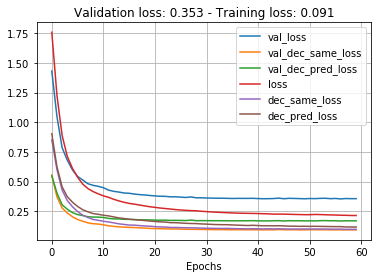

In [11]:
# Convert the history to a Pandas dataframe
hist_df = pd.DataFrame(hist.history)
hist_df.index.name = "Epochs"
# Save the training history
hist_df.to_hdf(save_path.format("hist.h5"), 'his')

# Plot training evolution
tit = "Validation loss: {:.3f} - Training loss: {:.3f}".format(*hist_df.min())
hist_df.plot(grid=True, title=tit)

### Evaluate the trained model

In [12]:
# Test the trained neural network against the test dataset
x_test = x_data[slc_tst]
y_test = y_data[slc_tst]
loss = ae.evaluate(x_test, [x_test, y_test])
print("Test dataset loss - Same: {:.3f} - Next: {:.3f}".format(*loss[1:]))

global_loss = ae.evaluate(x_data, [x_data, y_data])
print("Entire dataset loss - Same: {:.3f} - Next: {:.3f}".format(*global_loss[1:]))

140/140 [==============================] - 0s 2ms/step
Test dataset loss - Same: 0.131 - Next: 0.223
1401/1401 [==============================] - 1s 1ms/step
Entire dataset loss - Same: 0.103 - Next: 0.139


In [13]:
# Comparing the input and output of the autoencoder neural network
data_index = 634

# Slice the data
dt_in = x_data[data_index]
# Get the neural network output
dt_out, dt_out_nxt = ae.predict(dt_in[np.newaxis])
# Plot
alg = "Dual Convolutional Autoencoder"

Current time reconstruction

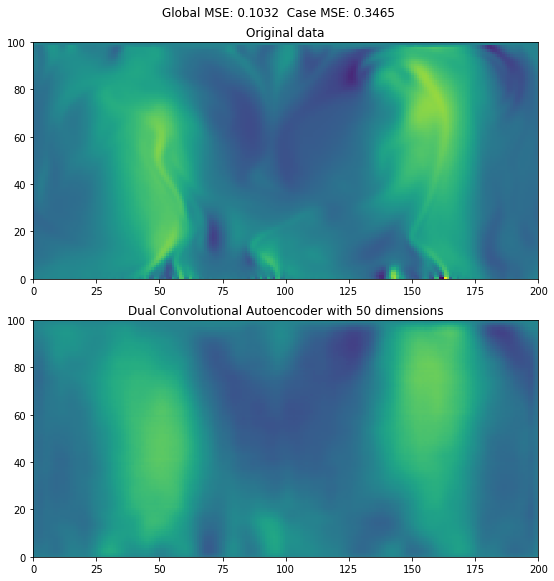

In [14]:
plot_red_comp(dt_in, dt_out[0], 0, lt_sz, global_loss[1], alg)

Next time step prediction

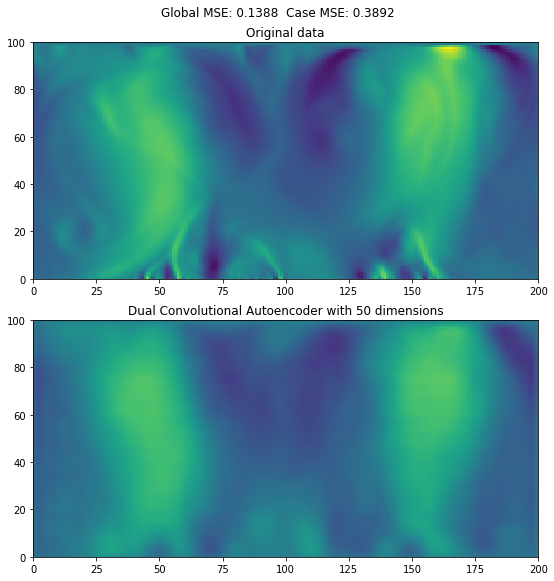

In [15]:
plot_red_comp(y_data[data_index], dt_out_nxt[0], 0, lt_sz, global_loss[2], alg)